<a id='top'></a>
---

# Tri-Vibe Sensor Integration
## Modbus Master Examples 
* Language: Python 3.7  
* Required Libraries + Used Versions: minimalmodbus @ 1.0.2 + Numpy @ 1.17.3 + Scipy @ 1.3.1 + Matplotlib @ 3.1.1
* Author: Leo Bach 12/18/2019
* Version: 3.01  
    (Virtual Zero Calculation Bug Fixed)  
    (Timestamp Improved)  
    (Local Snapshot Write Added)  
    (Snapshot Description Improved)  
* Email: leo@machinesaver.net  
* Phone: +1(832)581-9908

### Table of Contents:
[Part 1: Hardware Setup](#part1)  
[Part 2: Slave Addresses/RTU Number & Communication Settings](#part2)  
[Part 3: Tri-Vibe Modbus Implementation](#part3)  
[Part 4: Sensor Configuration & General Information Registers](#part4)  
[Part 5: Temperature](#part5)  
[Part 6: Overall Vibration](#part6)  
[Part 7: Configure Alarm Channels](#part7)  
[Part 8: Read Alarm Status](#part8)  
[Part 9: Analysis Data Parameter Setup](#part9)  
[Part 10: Analysis Data Capture Command & Verify Completion](#part10)  
[Part 11: Gather Captured Analysis Data From Tri-Vibe and Split into 3 Axis](#part11)  
[Part 12: Analysis Data RAW to Acceleration Conversion](#part12)  
<img src="./media/Triaxial_Timewave_Form.png" />
[Part 13: Windowing](#part13)  
(https://docs.scipy.org/doc/scipy/reference/signal.windows.html)  
[Part 14: Analysis Data FFT & Charting](#part14)  
<img src="./media/Triaxial_Spectrum.png" />
[Part 15: Create Local Snapshot File](#part15)  
[Part 16: Error Checking](#part16)  
[Vocabulary](#vocabulary)  
[Additional Resources](#resources)  

<a id="part1"></a>
---

## Part 1 --- Hardware Setup
### Required Hardware
* Tri-Vibe Sensor  
[Purchase Link](www.machinesaver.com)  
* RS485 to Serial Converter  
[Purchase Link](www.machinesaver.com)  
[Alternate Purchase Link](https://www.amazon.com/CH340-RS485-Converter-Adapter-Module/dp/B01N0JV0X4)  

### Wiring
<img src="./media/Master_Wiring.png" />  
<img src="./media/Multi_Trivibe_Wiring.png" />  

### Sensor Setup
1. Power your Tri-Vibe Sensor with 24VDC (Sensor LED will be Solid Green when powered).
2. Connect your Tri-Vibe Sensor to your computer via USB to Serial RS485 Converter. 
3. Find the USB to Serial RS485 converter's PORT location.

In [1]:
# import neccessary libraries
import minimalmodbus                        # modbus master library which supports Modbus RTU & Modbus ASCII but not Modbus TCP
import serial.tools.list_ports              # only used to find COM Port of your USB to RS485 Converter
import time                                 # use sleep to wait while sensor processes are happening + used to take timestamp when data is collected
from datetime import datetime               # manipulate timestamp to human readable date
import math                                 # used to manipulate numbers
import os                                   # used to save snapshots to snapshot directory within Machine Saver's Jupyter notebook

# import the neccessary libraries
import matplotlib.pyplot as plt            # charting library
from scipy.fftpack import fft               # fast fourier transform algorithm
import numpy as np                          # number manipulation - for creating time arrays and frequency bins arrays

In [2]:
# Find connected COM Ports Windows (RS485 to USB Converter)
ports = list(serial.tools.list_ports.comports())
if len(ports)==0:
    print('Please Plug A USB to RS485 Serial Converter in to Computer')
else:
    for p in ports:
        print (p)

COM5 - USB-SERIAL CH340 (COM5)


<a id="part2"></a>
---

## Part 2 --- Slave Addresses/RTU Number & Communication Settings
1. By convention Machine Saver produces Tri-Vibe Sensors with Slave Addresses matching the last 2 digits of the Tri-Vibe's serial number (we reserve slave address 0 and 1 for Modbus Masters and only increment from 2 - 99).
2. Update ```PORT = 'COM3'``` in the module below to match the location of your USB to RS485 Serial Converter.  
    * ```/dev/ttyUSB0``` (Linux)  
    * ```/dev/tty.usbserial``` (OS X)  
    * ```COM4``` (Windows)
3. Update ```SLAVE_ADDRESS = 72``` in the module below to the Slave Address of the Tri-Vibe.
4. Re-Run this Notebook after editing.

Note: It is possible to [Change the Tri-Vibe Slave Address](#part4) 

In [3]:
PORT = 'COM5'
SLAVE_ADDRESS = 44

if(SLAVE_ADDRESS!=0):
    trivibe = minimalmodbus.Instrument(PORT, SLAVE_ADDRESS)    # create a Modbus Slave object for the Tri-Vibe
else:
    print('Your SLAVE_ADDRESS should not be zero! Please change the value to the slave address of your Tri-Vibe.')

In [4]:
# update current slave settings for Tri-Vibe defaults and some useful variables
trivibe.serial.port                        # this is the serial port name
trivibe.address                            # this is the slave address (set this to the last 2 digits of the serial number of the Tri-Vibe that you want to communicate with)
trivibe.serial.baudrate = 115200           # Baudrate fixed 115200
trivibe.serial.bytesize = 8                # Bytesize fixed 8
trivibe.serial.parity   = "N"              # Parity fixed None 
trivibe.serial.stopbits = 1                # Stopbits fixed 1
trivibe.serial.timeout  = 0.10             # Seconds
trivibe.close_port_after_each_call = True  # Helps communication for Windows Devices (can be set to false on many Linux devices)
trivibe.mode = minimalmodbus.MODE_RTU      # modbus mode fixed RTU Mode
trivibe.clear_buffers_before_each_transaction = True


print(trivibe)                             # check updated slave communication settings

minimalmodbus.Instrument<id=0x156ad783f48, address=44, mode=rtu, close_port_after_each_call=True, precalculate_read_size=True, clear_buffers_before_each_transaction=True, handle_local_echo=False, debug=False, serial=Serial<id=0x156affd70c8, open=True>(port='COM5', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=0.1, xonxoff=False, rtscts=False, dsrdtr=False)>


<a id="part3"></a>
---

## Part 3 --- Tri-Vibe Modbus Implementation  

Tri-Vibe sensors exclusively communicate using the Modbus RTU communication protocol over a two-wire RS485 serial interface.  
All Modbus registers for the Tri-Vibe sensor are Holding Registers.  

| Object Type        | Access         | Size        |  
|--------------------|----------------|-------------|  
| ~~Coil~~           | ~~Read-write~~ | ~~1-bit~~   |  
| ~~Discrete Input~~ | ~~Read-only~~  | ~~1-bit~~   |  
| ~~Input Register~~ | ~~Read-only~~  | ~~16-bits~~ |  
| Holding Register   | Read-write     | 16-bits     |  

Although all Modbus holding registers are 16-bits we can combine 2 registers in some instances to create a 32-bit floating point value.  

Supported Function Codes:  
1. Function Code 0x03 for Reading Multiple Registers (If you only want to read 1 register just request a 1 for number of registers)

2. Function Code 0x10 for Writing Multiple Registers (If you only want to write 1 register just specify a 1 for number of registers)

<a id="part4"></a>
---

## Part 4 --- Sensor Configuration & General Information Registers

### IMPORTANT! Control Register (Register 1)
1. Register 1 is a Control Register
2. Writing a 1 to the Control Register will reboot the Tri-Vibe (try it to see your sensor flash green as it reboots).
3. Certain Tri-Vibe Registers require this register to be unlocked using the constant ```UNLOCK = [45555]``` to change configuration settings.
4. After configurations settings are changed the Control Register must be locked using the constant ```LOCK = [45556]``` again for the changes to get saved to the sensors Non-Volatile Memory.

### Changing Slave Address  
1. User Update the value ```NEW_SLAVE_ADDRESS = [#]```  
2. Unlock Control Register  
2. Write the NEW_SLAVE_ADDRESS value to Register 367  
3. Lock Control Register  
4. Reboot Tri-Vibe  
5. Change Target Slave Address for Modbus Master Library to NEW_SLAVE_ADDRESS  

In [5]:
# Sensor Configuration
UNLOCK = [45555]
LOCK = [45556]
NEW_SLAVE_ADDRESS = [0]

if(NEW_SLAVE_ADDRESS[0] != 0):
    # Unlock Control Register
    try:
        trivibe.write_registers(1, UNLOCK)
        print('Control Register Unlocked')
    except IOError:
        print('Failed to write to Tri-Vibe')
    # Change Sensor Slave Address
    try:
        trivibe.write_registers(367, NEW_SLAVE_ADDRESS)
        print('Slave Address Edited')
    except IOError:
        print('Failed to write to Tri-Vibe')
    # Lock Control Register
    try:
        trivibe.write_registers(1, LOCK)
        print('Control Register Locked')
    except IOError:
        print('Failed to write to Tri-Vibe')
    # Reboot Sensor
    try:
        trivibe.write_registers(1, [1])
        time.sleep(10)
        print('Sensor Rebooting')
    except IOError:
        print('Failed to write to Tri-Vibe')
    # Update Slave Address to New Address for our Tri-Vibe Object in minimal modbus
    try:
        trivibe = minimalmodbus.Instrument(PORT, NEW_SLAVE_ADDRESS[0])
        print('Tri-Vibe Slave Address Successfully changed')
    except IOError:
        print('Failed to read from Tri-Vibe')

### Read the Revision (Register 0)

In [6]:
try:
    sensor_revision = trivibe.read_registers(0, 1, functioncode=3)
    print('Sensor Software Revision:')                              # Revision at time of writing 112
    print(sensor_revision[0]-768)                                   # Remove the 768 from the output of register 0 to get the sensor's revision
except IOError:
    print('Failed to read from Tri-Vibe')

Sensor Software Revision:
109


### Read Tri-Vibe Uptime (Register 5,6,7)

In [7]:
try:
    sensor_uptime = trivibe.read_registers(5, 3, functioncode=3)  # register_number, number_of_registers, function_code
    print('Sensor Uptime:')
    print('Days- '+str(sensor_uptime[2]))                         # register 7
    print('Hours- '+str(sensor_uptime[1]))                        # register 6
    print('Minutes- '+str(sensor_uptime[0]))                      # register 5
except ModbusRequestError:
    print('Failed to read from Tri-Vibe')

Sensor Uptime:
Days- 0
Hours- 4
Minutes- 4


### Read the Serial Number (Register 27)

In [8]:
try:
    serial = trivibe.read_registers(27, 1, functioncode=3)
    print('Serial Number:')
    print(serial[0])
except IOError:
    print('Failed to read from Tri-Vibe')

Serial Number:
61244


### Read the Board Type (Register 366)

In [9]:
try:
    board = trivibe.read_registers(366, 1, functioncode=3)
    print('Board Type:')
    print(board[0])
except IOError:
    print('Failed to read from Tri-Vibe')

Board Type:
2


<a id="part5"></a>
---

## Part 5 --- Temperature (Register 31)

In [10]:
try:
    temperature = trivibe.read_registers(31, 1, functioncode=3)
    print('Degrees Celcius:')
    print(temperature[0]/10)                   # scale the temperature by dividing returned value by 10 to print correctly
except ModbusRequestError:
    print('Failed to read from Tri-Vibe')

Degrees Celcius:
11.7


<a id="part6"></a>
---

## Part 6 --- Overall Vibration (Register 172-219)  

|     Modbus Registers    | Acceleration (g RMS) | Velocity (in/sec RMS) |
|:-----------------------:|----------------------|-----------------------|
| Hybrid, Axis 1          |        172-173       |        178-179        |
| Hybrid, Axis 2          |        174-175       |        180-181        |
| Hybrid, Axis 3          |        176-177       |        182-183        |
| Accelerometer 1, Axis 1 |        190-191       |        196-197        |
| Accelerometer 1, Axis 2 |        192-193       |        198-199        |
| Accelerometer 1, Axis 3 |        194-195       |        200-201        |
| Accelerometer 2, Axis 1 |        208-209       |        214-215        |
| Accelerometer 2, Axis 2 |        210-211       |        216-217        |
| Accelerometer 2, Axis 3 |        212-213       |        218-219        |

***Hybrid*** Means that the modbus register will save the acceleration or velocity value of the lower-amplitude/higher-resolution accelerometer first, if the amplitude calculated from the signal exceeds the useful range of the lower-amplitude/higher-resolution accelerometer, the value of the higher-amplitude/lower-resolution accelerometer will be used.

In [11]:
# note the overall vibration registers are Floats are stored in two consecutive 16-bit registers in the slave.
# The encoding is according to the standard IEEE 754.
# Fortunately, minimal modbus library handles the conversions for us.

try:
    hybrid_acceleration_a1 = trivibe.read_float(172, functioncode=3, number_of_registers=2, byteorder=0)
    hybrid_acceleration_a2 = trivibe.read_float(174, functioncode=3, number_of_registers=2, byteorder=0)
    hybrid_acceleration_a3 = trivibe.read_float(176, functioncode=3, number_of_registers=2, byteorder=0)
    hybrid_velocity_a1 = trivibe.read_float(178, functioncode=3, number_of_registers=2, byteorder=0)
    hybrid_velocity_a2 = trivibe.read_float(180, functioncode=3, number_of_registers=2, byteorder=0)
    hybrid_velocity_a3 = trivibe.read_float(182, functioncode=3, number_of_registers=2, byteorder=0)
    accel_1_acceleration_a1 = trivibe.read_float(190, functioncode=3, number_of_registers=2, byteorder=0)
    accel_1_acceleration_a2 = trivibe.read_float(192, functioncode=3, number_of_registers=2, byteorder=0)
    accel_1_acceleration_a3 = trivibe.read_float(194, functioncode=3, number_of_registers=2, byteorder=0)
    accel_1_velocity_a1 = trivibe.read_float(196, functioncode=3, number_of_registers=2, byteorder=0)
    accel_1_velocity_a2 = trivibe.read_float(198, functioncode=3, number_of_registers=2, byteorder=0)
    accel_1_velocity_a3 = trivibe.read_float(200, functioncode=3, number_of_registers=2, byteorder=0)
    accel_2_acceleration_a1 = trivibe.read_float(208, functioncode=3, number_of_registers=2, byteorder=0)
    accel_2_acceleration_a2 = trivibe.read_float(210, functioncode=3, number_of_registers=2, byteorder=0)
    accel_2_acceleration_a3 = trivibe.read_float(212, functioncode=3, number_of_registers=2, byteorder=0)
    accel_2_velocity_a1 = trivibe.read_float(214, functioncode=3, number_of_registers=2, byteorder=0)
    accel_2_velocity_a2 = trivibe.read_float(216, functioncode=3, number_of_registers=2, byteorder=0)
    accel_2_velocity_a3 = trivibe.read_float(218, functioncode=3, number_of_registers=2, byteorder=0)
    print('hybrid_acceleration_a1: '+str(hybrid_acceleration_a1))
    print('hybrid_acceleration_a2: '+str(hybrid_acceleration_a2))
    print('hybrid_acceleration_a3: '+str(hybrid_acceleration_a3))
    print('hybrid_velocity_a1: '+str(hybrid_velocity_a1))
    print('hybrid_velocity_a2: '+str(hybrid_velocity_a2))
    print('hybrid_velocity_a3: '+str(hybrid_velocity_a3))
    print('accel_1_acceleration_a1: '+str(accel_1_acceleration_a1))
    print('accel_1_acceleration_a2: '+str(accel_1_acceleration_a2))
    print('accel_1_acceleration_a3: '+str(accel_1_acceleration_a3))
    print('accel_1_velocity_a1: '+str(accel_1_velocity_a1))
    print('accel_1_velocity_a2: '+str(accel_1_velocity_a2))
    print('accel_1_velocity_a3: '+str(accel_1_velocity_a3))
    print('accel_2_acceleration_a1: '+str(accel_2_acceleration_a1))
    print('accel_2_acceleration_a2: '+str(accel_2_acceleration_a2))
    print('accel_2_acceleration_a3: '+str(accel_2_acceleration_a3))
    print('accel_2_velocity_a1: '+str(accel_2_velocity_a1))
    print('accel_2_velocity_a2: '+str(accel_2_velocity_a2))
    print('accel_2_velocity_a3: '+str(accel_2_velocity_a3))
    
except ModbusRequestError:
    print('Failed to read from Tri-Vibe')

hybrid_acceleration_a1: 0.001693054335191846
hybrid_acceleration_a2: 0.0016990078147500753
hybrid_acceleration_a3: 0.0009346170118078589
hybrid_velocity_a1: 0.004003114067018032
hybrid_velocity_a2: 0.002860542619600892
hybrid_velocity_a3: 0.00255567766726017
accel_1_acceleration_a1: 0.001693054335191846
accel_1_acceleration_a2: 0.0016990078147500753
accel_1_acceleration_a3: 0.0009346170118078589
accel_1_velocity_a1: 0.004003114067018032
accel_1_velocity_a2: 0.002860542619600892
accel_1_velocity_a3: 0.00255567766726017
accel_2_acceleration_a1: 0.0018060043221339583
accel_2_acceleration_a2: 0.001953696832060814
accel_2_acceleration_a3: 0.0013874612050130963
accel_2_velocity_a1: 0.00414623087272048
accel_2_velocity_a2: 0.0030204053036868572
accel_2_velocity_a3: 0.0025944665540009737


<a id="part7"></a>
---

## Part 7 --- Configure Alarm Channels (Register 312-340)

<img src="./media/Hysteresis_Deadband.png" />  
<img src="./media/Alarm_Timeout_Trip_Delay.png" />  
<img src="./media/Frequency_Filters.png" />  

In [12]:
def type_check(x): # checks the type of alarm channel configuration
    return {
        0:'Unset',
        1:'Velocity',
        2:'Acceleration',
        3:'Displacement',
        4:'Temperature',
        5:'Impact Alert',
        6:'Danger Alert',
        7:'Detonation',
    }.get(x, 'error')    # 'error' is default if x not found

def axis_check(x): # checks the axis of alarm channel configuration
    return{
        0:'Unset',
        1:'Axis 1',
        2:'Axis 2',
        3:'Axis 3',
        4:'Temperature',
        5:'Not Used',
        6:'Not Used',
        7:'Detonation Axis 1',
        8:'Detonation Axis 2',
        9:'Detonation Axis 3',
        10:'Impact Threshold Axis 1',
        11:'Impact Threshold Axis 2',
        12:'Impact Threshold Axis 3',
        13:'Impact Count Axis 1',
        14:'Impact Count Axis 2',
        15:'Impact Count Axis 3',
    }.get(x, 'error')

try:
    # channel 1 settings
    alarm_channel_1_axis = trivibe.read_registers(312, 1, functioncode=3)
    print("Alarm Channel 1 Axis: "+axis_check(alarm_channel_1_axis[0]))
    alarm_channel_1_type = trivibe.read_registers(313, 1, functioncode=3)
    print("Alarm Channel 1 Type: "+type_check(alarm_channel_1_type[0]))
    alarm_channel_1_low_limit = trivibe.read_float(314, functioncode=3, number_of_registers=2, byteorder=0)
    print("Low: "+str(alarm_channel_1_low_limit))
    alarm_channel_1_high_limit = trivibe.read_float(316, functioncode=3, number_of_registers=2, byteorder=0)
    print("High: "+str(alarm_channel_1_high_limit))
    alarm_channel_1_high_high_limit = trivibe.read_float(318, functioncode=3, number_of_registers=2, byteorder=0)
    print("High-High: "+str(alarm_channel_1_high_high_limit))
    alarm_channel_1_hysteresis = trivibe.read_float(320, functioncode=3, number_of_registers=2, byteorder=0)
    print("Hysteresis: "+str(alarm_channel_1_hysteresis))
    
    # channel 2 settings
    alarm_channel_2_axis = trivibe.read_registers(312, 1, functioncode=3)
    print("Alarm Channel 2 Axis: "+axis_check(alarm_channel_2_axis[0]))
    alarm_channel_2_type = trivibe.read_registers(313, 1, functioncode=3)
    print("Alarm Channel 2 Type: "+type_check(alarm_channel_2_type[0]))
    alarm_channel_2_low_limit = trivibe.read_float(314, functioncode=3, number_of_registers=2, byteorder=0)
    print("Low: "+str(alarm_channel_2_low_limit))
    alarm_channel_2_high_limit = trivibe.read_float(316, functioncode=3, number_of_registers=2, byteorder=0)
    print("High: "+str(alarm_channel_2_high_limit))
    alarm_channel_2_high_high_limit = trivibe.read_float(318, functioncode=3, number_of_registers=2, byteorder=0)
    print("High-High: "+str(alarm_channel_2_high_high_limit))
    alarm_channel_2_hysteresis = trivibe.read_float(320, functioncode=3, number_of_registers=2, byteorder=0)
    print("Hysteresis: "+str(alarm_channel_2_hysteresis))
    
    # channel 3 settings
    alarm_channel_3_axis = trivibe.read_registers(322, 1, functioncode=3)
    print("Alarm Channel 3 Axis: "+axis_check(alarm_channel_3_axis[0]))
    alarm_channel_3_type = trivibe.read_registers(323, 1, functioncode=3)
    print("Alarm Channel 3 Type: "+type_check(alarm_channel_3_type[0]))
    alarm_channel_3_low_limit = trivibe.read_float(324, functioncode=3, number_of_registers=2, byteorder=0)
    print("Low: "+str(alarm_channel_3_low_limit))
    alarm_channel_3_high_limit = trivibe.read_float(326, functioncode=3, number_of_registers=2, byteorder=0)
    print("High: "+str(alarm_channel_3_high_limit))
    alarm_channel_3_high_high_limit = trivibe.read_float(328, functioncode=3, number_of_registers=2, byteorder=0)
    print("High-High: "+str(alarm_channel_3_high_high_limit))
    alarm_channel_3_hysteresis = trivibe.read_float(330, functioncode=3, number_of_registers=2, byteorder=0)
    print("Hysteresis: "+str(alarm_channel_3_hysteresis))
    
    # channel 4 settings
    alarm_channel_4_axis = trivibe.read_registers(332, 1, functioncode=3)
    print("Alarm Channel 4 Axis: "+axis_check(alarm_channel_4_axis[0]))
    alarm_channel_4_type = trivibe.read_registers(333, 1, functioncode=3)
    print("Alarm Channel 4 Type: "+type_check(alarm_channel_4_type[0]))
    alarm_channel_4_low_limit = trivibe.read_float(334, functioncode=3, number_of_registers=2, byteorder=0)
    print("Low: "+str(alarm_channel_4_low_limit))
    alarm_channel_4_high_limit = trivibe.read_float(336, functioncode=3, number_of_registers=2, byteorder=0)
    print("High: "+str(alarm_channel_4_high_limit))
    alarm_channel_4_high_high_limit = trivibe.read_float(338, functioncode=3, number_of_registers=2, byteorder=0)
    print("High-High: "+str(alarm_channel_4_high_high_limit))
    alarm_channel_4_hysteresis = trivibe.read_float(340, functioncode=3, number_of_registers=2, byteorder=0)
    print("Hysteresis: "+str(alarm_channel_4_hysteresis))

except ModbusRequestError:
    print('Failed to read from Tri-Vibe')

Alarm Channel 1 Axis: Axis 1
Alarm Channel 1 Type: Velocity
Low: -100000.0
High: 0.5
High-High: 100000.0
Hysteresis: 0.0
Alarm Channel 2 Axis: Axis 1
Alarm Channel 2 Type: Velocity
Low: -100000.0
High: 0.5
High-High: 100000.0
Hysteresis: 0.0
Alarm Channel 3 Axis: Axis 2
Alarm Channel 3 Type: Velocity
Low: -100000.0
High: 0.6499999761581421
High-High: 100000.0
Hysteresis: 0.0
Alarm Channel 4 Axis: Axis 3
Alarm Channel 4 Type: Velocity
Low: -100000.0
High: 0.699999988079071
High-High: 100000.0
Hysteresis: 0.0


<a id="part8"></a>
---

## Part 8 --- Read Alarm Status
Under Construction

<a id="part9"></a>
---

## Part 9 --- Analysis Data Parameter Setup
* From Internal Accelerometer (selected by Register 32)
* Collect This Number of Samples per Vibration Axis (selected by Register 36-37)
* Over This Number amount of time (selected by Register 35)

Note: These values are volatile and thus must be reset if the sensor loses power.

### Set/Read Capture --- Time (Register 35)  
Options: 10ms - 30000ms (increments of 10ms)

In [13]:
length_of_capture = [1000]

try:
    capture_time = trivibe.read_registers(35, 1, functioncode=3)
    print('capture_time: '+str(capture_time[0])+' milliseconds')
except IOError:
    print('Failed to read from Tri-Vibe')

if(capture_time[0]!=length_of_capture[0]):
    try:
        trivibe.write_registers(35, length_of_capture)
        print('capture_time updated: '+str(length_of_capture[0])+' milliseconds')
    except IOError:
        print('Failed to write to Tri-Vibe')

capture_time: 1000 milliseconds


### Set/Read Capture --- Which Accelerometer (Register 32)  

| Option | Result                   |
|--------|--------------------------|
| 5      | Internal Accelerometer 1 |
| 6      | Internal Accelerometer 2 |

In [14]:
internal_accel_select=[5]

try:
    internal_accel = trivibe.read_registers(32, 1, functioncode=3)
except IOError:
    print('Failed to read from Tri-Vibe')

if(internal_accel[0]!=internal_accel_select[0]):
    try:
        trivibe.write_registers(32, internal_accel_select)
        internal_accel = trivibe.read_registers(32, 1, functioncode=3)
        print('internal_accel updated: '+str(internal_accel[0]))
    except IOError:
        print('Failed to write to Tri-Vibe')

### Set/Read Capture --- Samples per Axis (Register 36-37)  
Options: 1 to 1,500,000 samples per axis  
#### Notes:  
* You should always select samples so that your sample rate is at least 2.56 times the highest frequency(hz) you want to resolve for, for a better understanding of this data type read through this [Other notebook](./About_Vibration_Spectrum_&_Timewave_Form.ipynb).  
* If the combination of samples_per_axis/capture_time > 50000 samples per second the Tri-Vibe will default to the max sample rate of 50000 samples per second. It will return the requested number of samples but the samples that are greater than our maximum sample rate will be filled by duplicating the previous sample.  
* data_array size will be 3 times the number of samples per axis specified because the data_array contains 3 axis of vibration information.  

In [15]:
samples_per_axis_select = 1024  # recommend to using powers of 2 for faster processing
                                            # - i.e. 256, 512, 1024, 2048, 4096, 8192, 16384, 524288, 1048576

try:
    samples_per_axis = trivibe.read_long(36, functioncode=3, signed=False, byteorder=0)
    print('samples_per_axis: '+str(samples_per_axis))
except IOError:
    print('Failed to read from Tri-Vibe')
    
if(samples_per_axis!=samples_per_axis_select):
    try:
        trivibe.write_long(36, samples_per_axis_select, signed=False, byteorder=0)
        print('samples_per_axis updated: '+str(samples_per_axis_select))
        samples_per_axis = trivibe.read_long(36, functioncode=3, signed=False, byteorder=0)
    except IOError:
        print('Failed to write to Tri-Vibe')

samples_per_axis: 1024


<a id="part10"></a>
---

## Part 10 --- Analysis Data Capture Command & Verify Completion (Register 33-34)  
Tell the Tri-Vibe to start capturing data based on the specified parameters from part 9 (Register 33)
Check Tri-Vibe capture engine to see if the collection is complete (Register 34)

### Trigger Analysis Data Capture (Register 33)  

In [16]:
TRIGGER_CAPTURE=[1]

try:
    trivibe.write_registers(33, TRIGGER_CAPTURE)
    timestamp = int(str(time.time())[slice(10)])                            # metadata to be used when displaying our charts to users, removes the portion of the timestamp beyond seconds
    snapshotTime = datetime.fromtimestamp(timestamp)                        # convert it to human readable format
    print(snapshotTime)
    print('capture event triggered on Tri-Vibe')
except IOError:
    print('Failed to write to Tri-Vibe')

2019-12-18 19:20:05
capture event triggered on Tri-Vibe


### Check Tri-Vibe Capture Engine Status (Register 34)  

| Status | Capture Engine Status                                                    |
|--------|--------------------------------------------------------------------------|
| 0      | IDLE. Doing nothing                                                      |
| 1      | CAPTURING DONE. Data is collected and ready to be read by client.        |
| 2      | IN PROGRESS. Actively collect data accordingly to configured parameters. |
| 3      | START ERROR. Something was going wrong. Bad parameters.                  |
| 4      | TIMEOUT ERROR. Something was going wrong.                                |


In [17]:
try:
    capture_engine_status = trivibe.read_registers(34, 1, functioncode=3)
    print('capture_engine_status: '+str(capture_engine_status[0]))           # show capture engine is busy (in progress)
except IOError:
    print('Failed to read from Tri-Vibe')
while capture_engine_status[0]==2:                                           # wait for data capture on the Tri-Vibe to complete
    capture_engine_status = trivibe.read_registers(34, 1, functioncode=3)
    time.sleep(2)
try:
    capture_engine_status = trivibe.read_registers(34, 1, functioncode=3)
    print('capture_engine_status: '+str(capture_engine_status[0]))           # show capture engine is complete (capturing done)
except IOError:
    print('Failed to read from Tri-Vibe')


capture_engine_status: 2
capture_engine_status: 0


<a id="part11"></a>
---

## Part 11 --- Gather Captured Analysis Data From Tri-Vibe and Split into 3 Axis
#### Data Array
* The Tri-Vibe orders the samples that it has collected as: axis_1_samples, axis_2_samples, axis_3_samples.  
* Samples can be read 122 samples at a time by reading modbus registers 50-171.  
* AUTOLOAD: when register 171 is successfully read, if there are more snapshot samples stored in the Tri-Vibe, the same set of registers (50-171) will be loaded with the next set of samples.
* Therefore if you had 122 samples_per_axis:  
    1. the first time reading registers 50-171 would return the entire sample set for Axis 1  
    2. after the successful read, the next 122 samples would be loaded into the modbus registers 50-171  
    3. the second time reading registers 50-171 would return the entire sample set for Axis 2  
    4. after the successful read, the next 122 samples would be loaded into the modbus registers 50-171  
    5. the thirds time reading registers 50-171 would return the entire sample set for Axis 3  

In [18]:
total_number_of_samples = samples_per_axis*3                              # how many samples are stored on the Tri-Vibe's buffer.
read_sets_required = math.ceil(total_number_of_samples/122)               # number of times we need to read Modbus Registers 50-171 to get all our samples back from our sensor
# print('expected final size of data array: '+str(total_number_of_samples))
# print('number of modbus reads required for 3 axis data_array: '+str(read_sets_required))

data_array =[]                                                             # where we will store 3 axis of RAW vibration data from the Tri-Vibe's internal accelerometer

while len(data_array)<total_number_of_samples:
    try:
        read_set = trivibe.read_registers(49, 123, functioncode=3)             # register_number, number_of_registers, function_code
        # print('start_sample: '+str(read_set[0]))                               # register 49
        # print('RAW_data: '+str(read_set[1:len(read_set)-1]))                   # register 50-171
        read_set.pop(0)                                                        # remove register 49 from read_set
        data_array.extend(read_set)                                            # take all values from the read_set and add them to our data array
        # print('data_array size: '+str(len(data_array)))                        # increments by 122 with each read... except for last read
    except IOError:
        print('Failed to read from Tri-Vibe')

data_array = data_array[0:total_number_of_samples]                             # remove any trailing zeroes from the last read_set
# print('data_array size: '+str(len(data_array)))

axis_1_data_array_RAW = data_array[0:samples_per_axis]                             # split data into 3 axes arrays
axis_2_data_array_RAW = data_array[samples_per_axis:samples_per_axis*2]
axis_3_data_array_RAW = data_array[samples_per_axis*2:samples_per_axis*3]

<a id="part12"></a>
---

## Part 12 --- Analysis Data RAW to Acceleration Conversion

Written Conversion Instructions
1. Above we split the RAW data into 3 arrays (one for each axis) and each of the 3 axis array has to be processed individually.
2. Get the Highest_Value and Lowest_Value from the RAW data Axis array.
3. Calculate the Virtual_Center_Line of the array:  
```Virtual_Center_Line = (Highest_Value-Lowest_Value)/2+ Lowest_Value```
4. The next steps need to be done for each item (sample) in the array:
5. Find the Difference from the Virtual Center Line  
If Raw_ADC_Value > Virtual_Center_Line  
    ```Difference_ADU = |Raw_ADC_Value - Virtual_Center_Line|```  
If Raw_ADC_Value < Virtual_Center_Line Difference_ADU  
    ```Difference_ADU = -|Raw_ADC_Value - Virtual_Center_Line|```  
If the RAW ADC Value = Virtual Center Line  
    ```Difference_ADU = 0```  
Find the Difference_mV  
    ```Difference_mV = Difference_ADU * Constant_K```  
Find the Acceleration_Amplitude  
    ```Acceleration_Amplitude = Difference_mV / Sensitivity```  

Constant_K – it is the number of millivolts in the circuit (3000) divided by the max number of counts from a 16 bit Analog to Digital Converter (65535).

Sensitivity – it is sensitivity of each axis of each internal accelerometer which is the value saved during sensor calibration and testing process at Machine Saver Inc.
Client can read these values from sensor using following Modbus registers

### Sensitivity Registers

| Modbus Registers | Internal Accelerometer 1 | Internal Accelerometer 2 |
|:----------------:|--------------------------|--------------------------|
| Axis 1           |          299-300         |          305-306         |
| Axis 2           |          301-302         |          307-308         |
| Axis 3           |          303-304         |          309-310         |


In [19]:
# pass a data_array of RAW values and an axis to the following function to convert them to (G PK) values

def convertRAWtoACCEL(aList, axis):
    """ Converts an Axis Data Array from RAW data to Acceleration Data Array"""
    if axis == 1:
        sensitivity = trivibe.read_float(299, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 2:
        sensitivity = trivibe.read_float(301, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 3:
        sensitivity = trivibe.read_float(303, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 4:
        sensitivity = trivibe.read_float(305, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 5:
        sensitivity = trivibe.read_float(307, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 6:
        sensitivity = trivibe.read_float(309, functioncode=3, number_of_registers=2, byteorder=0)
    
    constant_k = 3000/65535
    
    virtual_center = (max(aList)-min(aList))/2+min(aList)
    
    for position in range(len(aList)):
        if aList[position]>virtual_center:
            aList[position] = (abs(aList[position] - virtual_center)*constant_k)/sensitivity # if the value was above virtual center it will be positive for the timewave form
        elif aList[position]<virtual_center:
            aList[position] = (-abs(aList[position] - virtual_center)*constant_k)/sensitivity # if the value was below virtual center it will be negative for the timewave form
        else:
            aList[position] = 0 #if the value equals the virtual_center line we set it to zero for the timewave form

    return(aList)
    
if(internal_accel[0] == 5):                   # if internal accelerometer 1 was selected in the Analysis Data Setup Process
    axis_1_data_array_acceleration = convertRAWtoACCEL(axis_1_data_array_RAW, 1)
    axis_2_data_array_acceleration = convertRAWtoACCEL(axis_2_data_array_RAW, 2)
    axis_3_data_array_acceleration = convertRAWtoACCEL(axis_3_data_array_RAW, 3)
elif(internal_accel[0] == 6):                 # if internal accelerometer 2 was selected in the Analysis Data Setup Process
    axis_1_data_array_acceleration = convertRAWtoACCEL(axis_1_data_array_RAW, 4)
    axis_2_data_array_acceleration = convertRAWtoACCEL(axis_2_data_array_RAW, 5)
    axis_3_data_array_acceleration = convertRAWtoACCEL(axis_3_data_array_RAW, 6)
else:
    print("Internal Accelerometer Not Defined!")

<a id="part13"></a>
---

## Part 13 --- Windowing
Under Construction

<a id="part14"></a>
---

## Part 14 --- Analysis Data FFT & Charting

### Timewave Form Chart: Amplitude vs. Time  

Tri-Axial Timewave Form


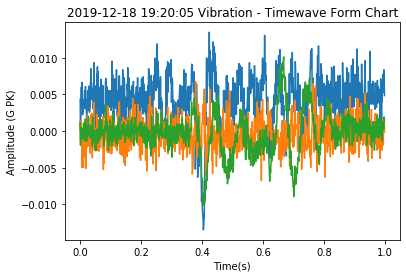

In [20]:
def chart_timewave_form(accel_data_array):
    """ Charts Axis Data Array """
    Fs = samples_per_axis/(length_of_capture[0]/1000)          # sampling frequency hertz (samples per second)
    # print(Fs)
    t = np.arange(0,length_of_capture[0]/1000,1/Fs)            # create a range of numbers from 0 to capture time (in seconds) at a specified interval (1/FrequencySampleRate)
    # print(t)
    y = accel_data_array                                       # TWF signal
    # print(y)
    plt.plot(t,y)                                              # create the timewave form plot for the generated sinewave
    plt.title(str(snapshotTime)+' Vibration - Timewave Form Chart')   
    plt.xlabel('Time(s)')                                      # time array (t) as the x-axis
    plt.ylabel('Amplitude (G PK)')                             # amplitude array (y) as the y-axis
    matrix = np.column_stack((t, y))                           # combine the x and y values into a matrix for storage in our twf snapshot file
    return matrix

print("Tri-Axial Timewave Form")
axis_1_twf = chart_timewave_form(axis_1_data_array_acceleration)             # axis 1 is blue on chart
axis_2_twf = chart_timewave_form(axis_2_data_array_acceleration)             # axis 2 is orange on chart
axis_3_twf = chart_timewave_form(axis_3_data_array_acceleration)             # axis 3 is green on chart

Axis 1 TWF


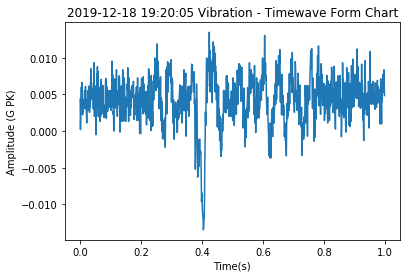

In [21]:
print("Axis 1 TWF")
axis_1_twf = chart_timewave_form(axis_1_data_array_acceleration)

Axis 2 TWF


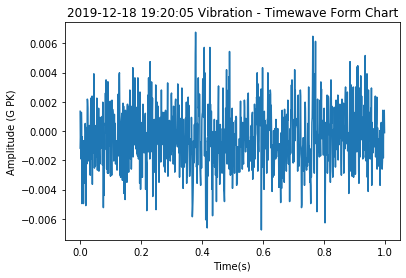

In [22]:
print("Axis 2 TWF")
axis_2_twf = chart_timewave_form(axis_2_data_array_acceleration)

Axis 3 TWF


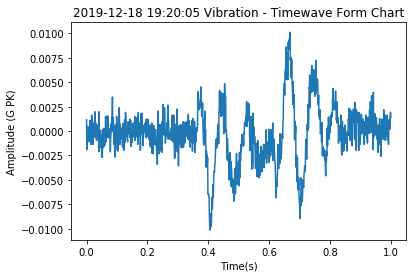

In [23]:
print("Axis 3 TWF")
axis_3_twf = chart_timewave_form(axis_3_data_array_acceleration)

### Fast Fourier Transform & Spectrum Chart: Amplitude vs. Frequency  

Tri-Axial Spectrum


C:\Users\Lukeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


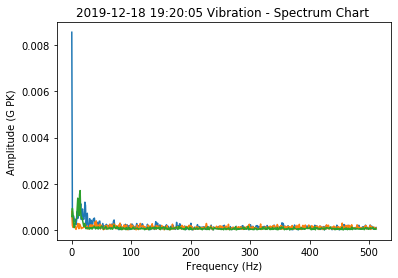

In [24]:
def transform_twf_to_spectrum(accel_data_array):
    """ Converts Acceleration data to Frequency data and then Charts the Frequency data """
    Fs = samples_per_axis/(length_of_capture[0]/1000)          # sampling frequency hertz (samples per second)
    t = np.arange(0,length_of_capture[0]/1000,1/Fs)            # create a range of numbers from 0 to capture time (in seconds) at a specified interval (1/FrequencySampleRate)
    y = accel_data_array                                       # TWF signal
    # convert twf to spectrum
    n = np.size(t) 
    Fbin = (Fs/2)*np.linspace(0,1,n/2)
    Y = fft(accel_data_array)
    Y_amplitude = (2/n)*abs(Y[0:np.size(Fbin)])
    # chart
    plt.plot(Fbin, Y_amplitude)
    plt.title(str(datetime.fromtimestamp(timestamp))+' Vibration - Spectrum Chart ')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (G PK)')
    matrix = np.column_stack((Fbin, Y_amplitude))               # combine the x and y values into a matrix for storage in our spectrum snapshot file
    return matrix

print("Tri-Axial Spectrum")
axis_1_spectrum = transform_twf_to_spectrum(axis_1_data_array_acceleration)             # axis 1 is blue on chart
axis_2_spectrum = transform_twf_to_spectrum(axis_2_data_array_acceleration)             # axis 2 is orange on chart
axis_3_spectrum = transform_twf_to_spectrum(axis_3_data_array_acceleration)             # axis 3 is green on chart

Axis 1 Spectrum


C:\Users\Lukeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


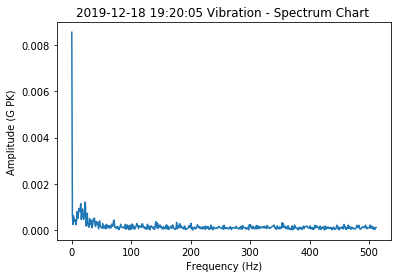

In [25]:
print("Axis 1 Spectrum")
axis_1_spectrum = transform_twf_to_spectrum(axis_1_data_array_acceleration)

Axis 2 Spectrum


C:\Users\Lukeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


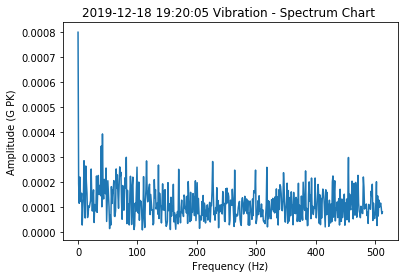

In [26]:
print("Axis 2 Spectrum")
axis_2_spectrum = transform_twf_to_spectrum(axis_2_data_array_acceleration)

Axis 3 Spectrum


C:\Users\Lukeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


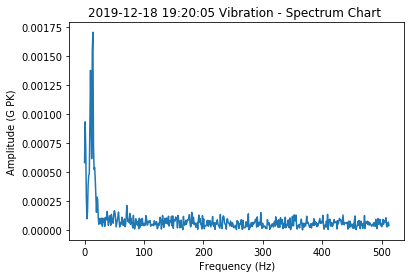

In [27]:
print("Axis 3 Spectrum")
axis_3_spectrum = transform_twf_to_spectrum(axis_3_data_array_acceleration)

<a id="part15"></a>
---

## Part 15 --- Create Local Snapshot File

In [28]:
def createSnapshotFiles(serialNumber, timestamp, axis1twf, axis2twf, axis3twf, axis1spec, axis2spec, axis3spec):
    cwd = os.getcwd()                                # save Jupyter notebook's directory
    os.chdir('snapshots')                            # move to snapshots directory
    print('saving snapshot files to: '+os.getcwd())
    with open(str(serialNumber)+'_'+str(timestamp)+'_a1_twf', "w+") as f:
        for item in axis1twf:
            f.write("%s\n" % item)
        f.close()
    with open(str(serialNumber)+'_'+str(timestamp)+'_a2_twf',"w+") as f:
        for item in axis2twf:
            f.write("%s\n" % item)
        f.close()
    with open(str(serialNumber)+'_'+str(timestamp)+'_a3_twf',"w+") as f:
        for item in axis3twf:
            f.write("%s\n" % item)
        f.close()
    with open(str(serialNumber)+'_'+str(timestamp)+'_a1_spec',"w+") as f:
        for item in axis1spec:
            f.write("%s\n" % item)
        f.close()
    with open(str(serialNumber)+'_'+str(timestamp)+'_a2_spec',"w+") as f:
        for item in axis1spec:
            f.write("%s\n" % item)
        f.close()
    with open(str(serialNumber)+'_'+str(timestamp)+'_a3_spec',"w+") as f:
        for item in axis3spec:
            f.write("%s\n" % item)
        f.close()
    os.chdir(cwd)                                    # get back to the original notebook directory
    

createSnapshotFiles(serial[0], timestamp, axis_1_twf, axis_2_twf, axis_3_twf, axis_1_spectrum, axis_2_spectrum, axis_3_spectrum)

saving snapshot files to: C:\Users\Lukeb\Jupyter\snapshots


<a id="part16"></a>
---

## Part 16 --- Error Checking
Under Construction

[Back to Top](#top)  

<a id="resources"></a>
---

## Additional Resources  
#### Python Libraries  
[MinimalModbus Library Documentation](https://minimalmodbus.readthedocs.io/en/master/usage.html)  
[MinimalModbus Github](https://github.com/pyhys/minimalmodbus)  
[Numpy & Scipy Library Documentation](https://docs.scipy.org/doc/)  
[Matplotlib Library Documentation](https://matplotlib.org/3.1.1/contents.html)  
#### Vibration Analysis  
[An Introduction to Machine Vibration Analysis](https://www.youtube.com/watch?v=Vj1xmze3GlE)  
[Understanding the Time Waveform (Composed of Individual Sine Waves)](https://www.youtube.com/watch?v=r18Gi8lSkfM&t=561s)  
[Practical Understanding of the FFT & Windowing](https://www.youtube.com/watch?v=FjmwwDHT98c)  
[Another Non-Mathematical FFT Explanation](https://www.youtube.com/watch?v=dCeHOf4cJE0)  